In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [3]:
BASE_DIR            = "/content/gdrive/MyDrive"
TRAIN_IMAGES_PATH   = os.path.join(BASE_DIR, "train")
TEST_IMAGES_PATH    = os.path.join(BASE_DIR, "test")
TRAIN_METADATA_PATH = os.path.join(BASE_DIR, "ISIC_2020_Train_Metadata.csv")
TEST_METADATA_PATH  = os.path.join(BASE_DIR, "ISIC_2020_Test_Metadata.csv")

In [4]:
train_files = os.listdir(TRAIN_IMAGES_PATH)
test_files  = os.listdir(TEST_IMAGES_PATH)

print("Train total number of images:", len(train_files))
print("Test total number of images: ", len(test_files))

Train total number of images: 1000
Test total number of images:  436


Read Metadata.csv files

In [5]:
train_metadata = pd.read_csv(TRAIN_METADATA_PATH)
test_metadata  = pd.read_csv(TEST_METADATA_PATH)

print("Train Metadata shape:", train_metadata.shape)
print("Test Metadata shape: ", test_metadata.shape)

Train Metadata shape: (1000, 9)
Test Metadata shape:  (1000, 5)


Adding .jpg to the image_name column

In [6]:
train_metadata['image_name_with_ext'] = train_metadata['image_name'].astype(str) + ".jpg"
test_metadata ['image_name_with_ext'] = test_metadata ['image'].astype(str) + ".jpg"

Adding the images in a set

In [7]:
train_image_files = set(os.listdir(TRAIN_IMAGES_PATH))
test_image_files  = set(os.listdir(TEST_IMAGES_PATH))

Filter the set

In [8]:
filtered_train = train_metadata[train_metadata['image_name_with_ext'].isin(train_image_files)].copy()
print("Train size filtered by file:", len(filtered_train))

Train size filtered by file: 1000


Ensure that each class have at least two samples

In [9]:
class_counts   = filtered_train['diagnosis'].value_counts()
valid_classes  = class_counts[class_counts > 1].index
filtered_train = filtered_train[filtered_train['diagnosis'].isin(valid_classes)].copy()
print("Train size after removing classes with few samples:", len(filtered_train))

Train size after removing classes with few samples: 999


Map the label to integer

In [10]:
label_mapping = {label: idx for idx, label in enumerate(filtered_train['diagnosis'].unique())}
filtered_train['label'] = filtered_train['diagnosis'].map(label_mapping)

if 'diagnosis' in test_metadata.columns:
    test_metadata['label'] = test_metadata['diagnosis'].map(label_mapping)
else:
    test_metadata['label'] = pd.NA

Split train and test data


In [11]:
train_df, val_df = train_test_split(
    filtered_train,
    test_size=0.20,
    stratify=filtered_train['label'],
    random_state=42
)

print("Training set size:   ", len(train_df))
print("Validation set size:", len(val_df))

Training set size:    799
Validation set size: 200


Plot the Class Distribution

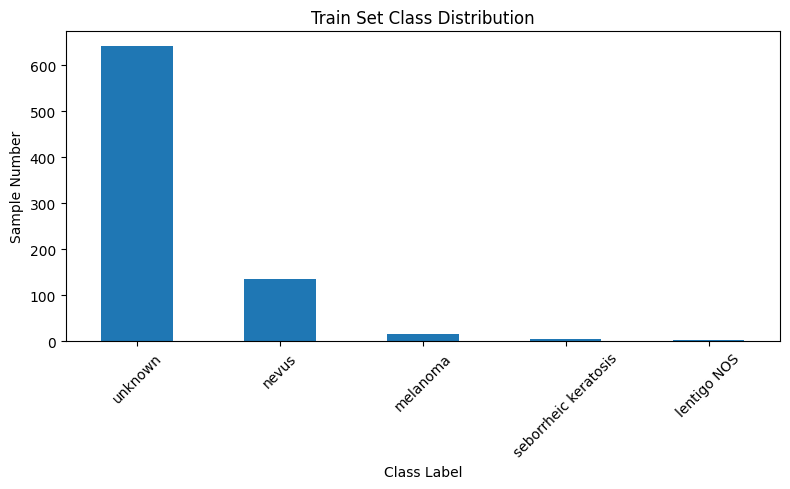

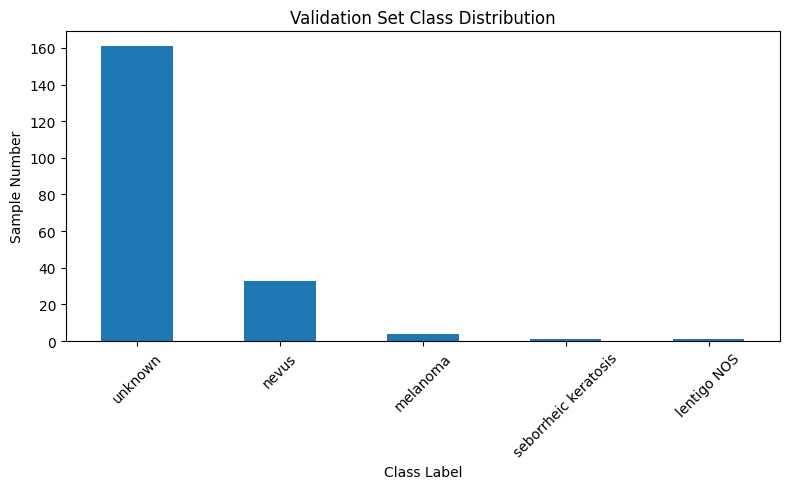

In [12]:
import matplotlib.pyplot as plt

def plot_class_distribution(df, label_col='diagnosis', title='Class Distribution'):
    class_counts = df[label_col].value_counts()

    plt.figure(figsize=(8, 5))
    class_counts.plot(kind='bar')
    plt.xlabel('Class Label')
    plt.ylabel('Sample Number')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_df, label_col='diagnosis', title='Train Set Class Distribution')
plot_class_distribution(val_df,   label_col='diagnosis', title='Validation Set Class Distribution')

Visualize the samples

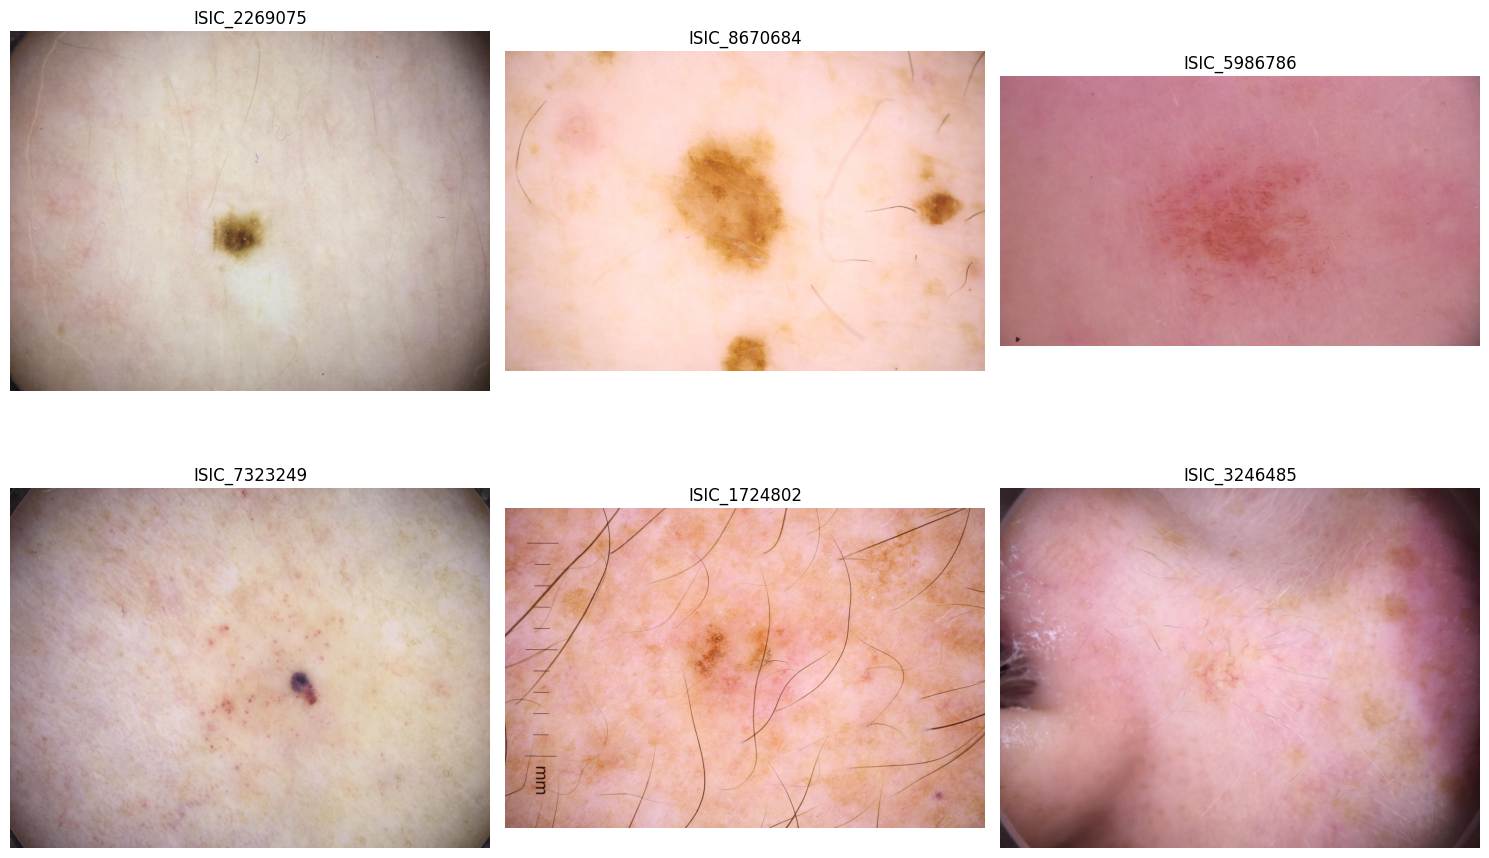

In [13]:
def visualize_samples(image_dir, metadata_df, num_samples=6):
    if metadata_df.empty:
        print("\nVisualize: metadata is empty, no examples to show.")
        return
    sample_images = metadata_df.sample(num_samples, random_state=42)
    plt.figure(figsize=(15, 10))
    for idx, (_, row) in enumerate(sample_images.iterrows()):
        img_path = os.path.join(image_dir, row['image_name_with_ext'])
        img      = cv2.imread(img_path)
        img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, idx + 1)
        plt.imshow(img)
        base_name = row['image_name_with_ext'].rsplit('.', 1)[0]
        plt.title(base_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_IMAGES_PATH, filtered_train)

PyTorch Dataset Class

In [14]:
class ISICDataset(Dataset):
    def __init__(self, metadata_df, image_dir, transform=None):
        self.metadata  = metadata_df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row      = self.metadata.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_name_with_ext'])
        image    = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(row['label']) if not pd.isna(row['label']) else -1

        if self.transform:
            image = self.transform(image)
        return image, label

Data Transforms

In [15]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

DataLoaders

In [16]:
if not train_df.empty:
    train_dataset = ISICDataset(train_df, TRAIN_IMAGES_PATH, transform=data_transforms)
    val_dataset   = ISICDataset(val_df,   TRAIN_IMAGES_PATH, transform=data_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    print("\nTrain/Val data loaders were successfully prepared.")
    images, labels = next(iter(train_loader))
    print("Example batch (image) size:", images.size())
    print("Example batch (label) size:", labels.size())
else:
    print("\nThere is not enough data to create a data loader.")


Train/Val data loaders were successfully prepared.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Example batch (image) size: torch.Size([32, 3, 224, 224])
Example batch (label) size: torch.Size([32])


Balancing Data

In [17]:
num_classes  = len(label_mapping)
total_wanted = 1000

base_per_class = total_wanted // num_classes
remainder      = total_wanted - base_per_class * num_classes

targets_per_class = {cls: base_per_class for cls in range(num_classes)}
for i, cls in enumerate(label_mapping.values()):
    if i < remainder:
        targets_per_class[i] += 1

print("Goal numbers (for each class):", targets_per_class, "\n")

rng = np.random.default_rng(42)
y_all = filtered_train['label'].values
idx_by_class = [np.where(y_all == c)[0] for c in range(num_classes)]

balanced_indices = []
for cls in range(num_classes):
    idx_cls   = idx_by_class[cls]
    n_target  = targets_per_class[cls]
    if n_target <= len(idx_cls):
        chosen = rng.choice(idx_cls, size=n_target, replace=False)
    else:
        extra  = rng.choice(idx_cls, size=(n_target - len(idx_cls)), replace=True)
        chosen = np.concatenate([idx_cls, extra])
    balanced_indices.append(chosen)

balanced_indices = np.concatenate(balanced_indices)
balanced_indices = rng.permutation(balanced_indices)

balanced_df = filtered_train.iloc[balanced_indices].reset_index(drop=True)
assert len(balanced_df) == total_wanted

print("Total samples after balancing:", len(balanced_df))
print("Class distribution after balancing:\n", balanced_df['diagnosis'].value_counts(), "\n")

Goal numbers (for each class): {0: 200, 1: 200, 2: 200, 3: 200, 4: 200} 

Total samples after balancing: 1000
Class distribution after balancing:
 diagnosis
nevus                   200
unknown                 200
lentigo NOS             200
seborrheic keratosis    200
melanoma                200
Name: count, dtype: int64 



Split Balanced Data

In [18]:
train_balanced_df, val_balanced_df = train_test_split(
    balanced_df,
    test_size=0.20,
    stratify=balanced_df['label'],
    random_state=42
)

# Handcrafted Methods

In [19]:
from skimage.measure import regionprops, label

def extract_handcrafted_features(image_bgr):
    blurred = cv2.GaussianBlur(image_bgr, (5, 5), 0)
    blurred = cv2.medianBlur(blurred, 5)

    gray      = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened  = cv2.morphologyEx(binary, cv2.MORPH_OPEN,  kernel, iterations=2)
    closed  = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)

    label_img = label(closed)
    props     = regionprops(label_img)
    if len(props) > 0:
        largest_region = max(props, key=lambda x: x.area)
        mask = (label_img == largest_region.label).astype(np.uint8)
    else:
        mask = np.zeros_like(gray)

    image_rgb     = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    masked_pixels = image_rgb[mask == 1]
    if masked_pixels.size == 0:
        mean_color = np.zeros(3)
        std_color  = np.zeros(3)
    else:
        mean_color = masked_pixels.mean(axis=0)
        std_color  = masked_pixels.std(axis=0)

    p = None
    area, perimeter = 0, 0
    hu_moments      = np.zeros(7)
    if len(props) > 0:
        p         = largest_region
        area      = p.area
        perimeter = p.perimeter
        moments   = cv2.moments(mask.astype(np.uint8))
        hu_moments = cv2.HuMoments(moments).flatten()

    gray_for_glcm = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    distances     = [1]
    angles        = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm    = graycomatrix(
        gray_for_glcm,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True
    )

    contrast    = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()

    feats = np.hstack([
        mean_color,
        std_color,
        [area, perimeter],
        hu_moments,
        [contrast, homogeneity]
    ])

    return feats

In [20]:
X_handcrafted_train = []
y_train_labels      = []

for idx, row in tqdm(train_balanced_df.iterrows(), total=len(train_balanced_df), desc="Extract features for balanced train"):
    img_name  = row['image_name_with_ext']
    img_path  = os.path.join(TRAIN_IMAGES_PATH, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        X_handcrafted_train.append(np.zeros(3 + 3 + 2 + 7 + 2))
        y_train_labels.append(row['label'])
        continue

    feats = extract_handcrafted_features(image_bgr)
    X_handcrafted_train.append(feats)
    y_train_labels.append(row['label'])

X_handcrafted_train = np.array(X_handcrafted_train)
y_train_labels      = np.array(y_train_labels)


X_handcrafted_val = []
y_val_labels      = []

for idx, row in tqdm(val_balanced_df.iterrows(), total=len(val_balanced_df), desc="Extract features for balanced val"):
    img_name  = row['image_name_with_ext']
    img_path  = os.path.join(TRAIN_IMAGES_PATH, img_name)
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        X_handcrafted_val.append(np.zeros(3 + 3 + 2 + 7 + 2))
        y_val_labels.append(row['label'])
        continue

    feats = extract_handcrafted_features(image_bgr)
    X_handcrafted_val.append(feats)
    y_val_labels.append(row['label'])

X_handcrafted_val = np.array(X_handcrafted_val)
y_val_labels      = np.array(y_val_labels)

scaler         = StandardScaler().fit(X_handcrafted_train)
X_train_scaled = scaler.transform(X_handcrafted_train)
X_val_scaled   = scaler.transform(X_handcrafted_val)

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=42
)
svm_clf.fit(X_train_scaled, y_train_labels)

y_pred_val = svm_clf.predict(X_val_scaled)
print("\nBalanced Traditional Handcrafted + SVM Validation Results")
print("Accuracy:", accuracy_score(y_val_labels, y_pred_val))
print("\nClassification Report:")
print(classification_report(y_val_labels, y_pred_val, target_names=list(label_mapping.keys())))

Extract features for balanced val: 100%|██████████| 200/200 [05:55<00:00,  1.78s/it]


Balanced Traditional Handcrafted + SVM Validation Results
Accuracy: 0.87

Classification Report:
                      precision    recall  f1-score   support

               nevus       0.92      0.82      0.87        40
             unknown       0.81      0.62      0.70        40
            melanoma       0.80      0.90      0.85        40
         lentigo NOS       0.95      1.00      0.98        40
seborrheic keratosis       0.87      1.00      0.93        40

            accuracy                           0.87       200
           macro avg       0.87      0.87      0.87       200
        weighted avg       0.87      0.87      0.87       200



# CNN / Transfer Learning

In [21]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import os
from tqdm import tqdm

In [22]:
train_dataset = ISICDataset(train_balanced_df, TRAIN_IMAGES_PATH, transform=data_transforms)
val_dataset = ISICDataset(val_balanced_df, TRAIN_IMAGES_PATH, transform=data_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Simple CNN

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)

        input = torch.zeros(1, 3, 224, 224)
        x = self.pool(F.relu(self.conv1(input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self.flat_dim = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flat_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)

        return x

Transfer Model

In [24]:
def create_transfer_model(model_name = 'resnet50', num_classes = 7, pretrained= True):
    if model_name == 'resnet50':
      model = models.resnet50(pretrained=pretrained)
      feature_num = model.fc.in_features
      model.fc = nn.Linear(feature_num, num_classes)
    elif model_name == 'vit_b_16':
        model = models.vit_b_16(pretrained=pretrained)
        feature_num = model.heads.head.in_features
        model.heads.head = nn.Linear(feature_num, num_classes)

    return model

Training Function

In [25]:
def train(model, dataloaders, calc_loss, optimizer, numberOfEpoch, early_stop, device, dtype):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 1e7
    early_stop_counter = 0
    train_loss_list = []
    val_loss_list = []

    total_memory = f'{torch.cuda.get_device_properties(0).total_memory/ 1E9 if torch.cuda.is_available() else 0:.3g}G'
    for epoch in range(0, numberOfEpoch):
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            epoch_loss = 0.0
            correct_prediction = 0.0
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            batch_step = 0
            batch_size = dataloaders[phase].batch_size
            with tqdm(dataloaders[phase], unit="batch") as tbar:
                for input_imgs, gt_labels in tbar:
                    tbar.set_description(f"Epoch {epoch}")
                    batch_step += 1
                    input_imgs = input_imgs.to(device).type(dtype)
                    gt_labels = gt_labels.to(device).long()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(input_imgs)
                      loss = calc_loss(outputs, gt_labels.long())

                      if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * input_imgs.size(0)
                    _, predictions = torch.max(outputs, 1)
                    correct_prediction += torch.sum(predictions == gt_labels.data).item()

            epoch_loss = epoch_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_prediction / len(dataloaders[phase].dataset)

            if phase == 'train':
              train_loss_list.append(epoch_loss)

            else:

              val_loss_list.append(epoch_loss)

              if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model.state_dict())
                early_stop_counter = 0

              else:
                early_stop_counter += 1

                if early_stop_counter >= early_stop:
                  break
        else:
          continue
        break


    return best_model, train_loss_list, val_loss_list

Evaluation Function

In [26]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    predictions = []
    labels_list = []
    probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    predictions = np.array(predictions)
    labels = np.array(labels_list)
    probabilities = np.array(probabilities)

    # Evaluation metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, average='weighted')

    classification_rep = classification_report(labels, predictions,
                                             target_names=class_names, output_dict=True)

    try:
        if len(class_names) == 2:
            auc = roc_auc_score(labels, probabilities[:, 1])
        else:
            auc = roc_auc_score(labels, probabilities, multi_class='ovr', average='weighted')
    except:
        auc = None

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': predictions,
        'true_labels': labels,
        'probabilities': probabilities,
        'classification_report': classification_rep
    }

    return results

In [27]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    return cm

Parameters

In [28]:
import copy
device = "cuda:0"
dtype = torch.cuda.FloatTensor

model = create_transfer_model(model_name = 'resnet50', num_classes=len(label_mapping), pretrained=True)
model = model.to(device)

dataloaders = { 'train': train_loader, 'val': val_loader }

lrRate = 3e-5
weightDecay = 1e-4
numberOfEpoch = 25
early_stop = 7


optimizer = optim.Adam(model.parameters(), lr=lrRate, weight_decay=weightDecay)
calc_loss = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


Training with best CNN model

In [ ]:
best_model, train_loss, val_loss = train(model, dataloaders, calc_loss, optimizer, numberOfEpoch, early_stop, device, dtype)
model.load_state_dict(best_model)

Epoch 0:  57%|█████▋    | 4/7 [00:17<00:07,  2.54s/batch]

Evaluation

In [ ]:
import seaborn as sns

class_names = list(label_mapping.keys())
cnn_results = evaluate_model(model, val_loader, device, class_names)

print(" CNN Evaluation Results ")
print(f"Accuracy:  {cnn_results['accuracy']:.4f}")
print(f"Precision: {cnn_results['precision']:.4f}")
print(f"Recall:    {cnn_results['recall']:.4f}")
print(f"F1-score:  {cnn_results['f1']:.4f}")
print(f"AUC:       {cnn_results['auc']:.4f}")

print("\n===== Classification Report =====")
import pandas as pd
pd.set_option("display.max_columns", None)
report_df = pd.DataFrame(cnn_results['classification_report']).transpose()
display(report_df)

plot_confusion_matrix(cnn_results['true_labels'], cnn_results['predictions'], class_names)



# Statistical Test & Standart Deviation Analysis

In [ ]:
!pip install statsmodels

import numpy as np
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd


Cross validation for handcrafted

In [ ]:
def cross_validate_handcrafted(X, y, cv_folds=5, random_state=42):
    skfold = StratifiedKFold(n_splits = cv_folds, shuffle = True, random_state=random_state)

    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    fold_predictions = []
    fold_true_labels = []

    for fold, (train_idx, val_idx) in enumerate(skfold.split(X, y)):
        print(f"Processing fold {fold + 1}/{cv_folds} for handcrafted features...")

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)

        svm_clf = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            random_state=42
        )
        svm_clf.fit(X_train_scaled, y_train_fold)

        y_pred = svm_clf.predict(X_val_scaled)

        accuracies.append(accuracy_score(y_val_fold, y_pred))
        f1_scores.append(f1_score(y_val_fold, y_pred, average='weighted'))
        precisions.append(precision_score(y_val_fold, y_pred, average='weighted'))
        recalls.append(recall_score(y_val_fold, y_pred, average='weighted'))

        fold_predictions.extend(y_pred)
        fold_true_labels.extend(y_val_fold)

    return {
        'accuracies': np.array(accuracies),
        'f1_scores': np.array(f1_scores),
        'precisions': np.array(precisions),
        'recalls': np.array(recalls),
        'all_predictions': np.array(fold_predictions),
        'all_true_labels': np.array(fold_true_labels)
    }


Cross validation for CNN

In [ ]:
def cross_validate_cnn(train_balanced_df, image_dir, transform, label_mapping, cv_folds=5, random_state=42):

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    fold_predictions = []
    fold_true_labels = []

    # Prepare data for cross-validation
    X_indices = np.arange(len(train_balanced_df))
    y = train_balanced_df['label'].values

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_indices, y)):
        print(f"Processing fold {fold + 1}/{cv_folds} for CNN...")

        # data loaders
        train_fold_df = train_balanced_df.iloc[train_idx].reset_index(drop=True)
        val_fold_df = train_balanced_df.iloc[val_idx].reset_index(drop=True)

        train_dataset_fold = ISICDataset(train_fold_df, image_dir, transform=transform)
        val_dataset_fold = ISICDataset(val_fold_df, image_dir, transform=transform)

        train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True, num_workers=2)
        val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False, num_workers=2)

        #Training
        model = create_transfer_model(model_name='resnet50', num_classes=len(label_mapping), pretrained=True)
        model = model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)
        calc_loss = nn.CrossEntropyLoss()

        dataloaders_fold = {'train': train_loader_fold, 'val': val_loader_fold}

        best_model, _, _ = train(model, dataloaders_fold, calc_loss, optimizer,
                                numberOfEpoch=10, early_stop=5, device=device, dtype=dtype)
        model.load_state_dict(best_model)

        # Evaluate
        model.eval()
        predictions = []
        current_labels = []

        with torch.no_grad():
            for images, labels in val_loader_fold:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                predictions.extend(preds.cpu().numpy())
                current_labels.extend(labels.cpu().numpy())

        predictions = np.array(predictions)
        current_labels = np.array(current_labels)

        # Calculate metrics
        accuracies.append(accuracy_score(labels, predictions))
        f1_scores.append(f1_score(labels, predictions, average='weighted'))
        precisions.append(precision_score(labels, predictions, average='weighted'))
        recalls.append(recall_score(labels, predictions, average='weighted'))

        fold_predictions.extend(predictions)
        fold_true_labels.extend(current_labels)

        # Clear GPU memory
        del model
        torch.cuda.empty_cache()

    return {
        'accuracies': np.array(accuracies),
        'f1_scores': np.array(f1_scores),
        'precisions': np.array(precisions),
        'recalls': np.array(recalls),
        'all_predictions': np.array(fold_predictions),
        'all_true_labels': np.array(fold_true_labels)
    }

In [ ]:
def perform_statistical_tests(handcrafted_results, cnn_results):

    print("="*30)
    print("STATISTICAL COMPARISON RESULTS")
    print("="*30)

    # Metrics
    handcrafted_accuracy = handcrafted_results['accuracies']
    cnn_accuracy = cnn_results['accuracies']

    handcrafted_f1 = handcrafted_results['f1_scores']
    cnn_f1 = cnn_results['f1_scores']

    handcrafted_precision = handcrafted_results['precisions']
    cnn_precision = cnn_results['precisions']

    handcrafted_recall = handcrafted_results['recalls']
    cnn_recall = cnn_results['recalls']

    # Calculate means and standard deviations
    results_summary = pd.DataFrame({
        'Handcrafted Features + SVM': [
            f"{handcrafted_accuracy.mean():.4f} ± {handcrafted_accuracy.std():.4f}",
            f"{handcrafted_f1.mean():.4f} ± {handcrafted_f1.std():.4f}",
            f"{handcrafted_precision.mean():.4f} ± {handcrafted_precision.std():.4f}",
            f"{handcrafted_recall.mean():.4f} ± {handcrafted_recall.std():.4f}"
        ],
        'CNN (ResNet50)': [
            f"{cnn_accuracy.mean():.4f} ± {cnn_accuracy.std():.4f}",
            f"{cnn_f1.mean():.4f} ± {cnn_f1.std():.4f}",
            f"{cnn_precision.mean():.4f} ± {cnn_precision.std():.4f}",
            f"{cnn_recall.mean():.4f} ± {cnn_recall.std():.4f}"
        ]
    }, index=['Accuracy', 'F1-Score', 'Precision', 'Recall'])

    print("\nCROSS-VALIDATION RESULTS (Mean ± Std)")
    print("-" * 60)
    display(results_summary)


    # PAIRED T-TEST
    print("\nPAIRED T-TEST RESULTS")
    print("-" * 30)

    t_stat_acc, p_val_acc = ttest_rel(cnn_accuracy, handcrafted_accuracy)
    print(f"Accuracy: t-statistic = {t_stat_acc:.4f}, p-value = {p_val_acc:.4f}")

    t_stat_f1, p_val_f1 = ttest_rel(cnn_f1, handcrafted_f1)
    print(f"F1-Score: t-statistic = {t_stat_f1:.4f}, p-value = {p_val_f1:.4f}")

    t_stat_prec, p_val_prec = ttest_rel(cnn_precision, handcrafted_precision)
    print(f"Precision: t-statistic = {t_stat_prec:.4f}, p-value = {p_val_prec:.4f}")

    t_stat_rec, p_val_rec = ttest_rel(cnn_recall, handcrafted_recall)
    print(f"Recall: t-statistic = {t_stat_rec:.4f}, p-value = {p_val_rec:.4f}")


    # WILCOXON SIGNED-RANK TEST (non-parametric alternative)
    print("\nWILCOXON SIGNED-RANK TEST RESULTS")
    print("-" * 30)

    w_stat_acc, w_p_acc = wilcoxon(cnn_accuracy, handcrafted_accuracy)
    print(f"Accuracy: W-statistic = {w_stat_acc:.4f}, p-value = {w_p_acc:.4f}")

    w_stat_f1, w_p_f1 = wilcoxon(cnn_f1, handcrafted_f1)
    print(f"F1-Score: W-statistic = {w_stat_f1:.4f}, p-value = {w_p_f1:.4f}")



    # MCNEMAR'S TEST
    print("\nMCNEMAR'S TEST")
    print("-" * 30)

    handcrafted_pred = handcrafted_results['all_predictions']
    cnn_pred = cnn_results['all_predictions']
    true_labels = handcrafted_results['all_true_labels']


    # Create contingency table
    handcrafted_correct = (handcrafted_pred == true_labels)
    cnn_correct = (cnn_pred == true_labels)

    # Both correct
    both_correct = np.sum(handcrafted_correct & cnn_correct)
    # Both wrong
    both_wrong = np.sum(~handcrafted_correct & ~cnn_correct)
    # Handcrafted correct, CNN wrong
    handcrafted_right_cnn_wrong = np.sum(handcrafted_correct & ~cnn_correct)
    # CNN correct, Handcrafted wrong
    cnn_right_handcrafted_wrong = np.sum(cnn_correct & ~handcrafted_correct)

    print(f"Both correct: {both_correct}")
    print(f"Both wrong: {both_wrong}")
    print(f"Handcrafted correct, CNN wrong: {handcrafted_right_cnn_wrong}")
    print(f"CNN correct, Handcrafted wrong: {cnn_right_handcrafted_wrong}")

    # McNemar's test
    contingency_table = np.array([[both_correct, handcrafted_right_cnn_wrong],
                                  [cnn_right_handcrafted_wrong, both_wrong]])

    try:
        mcnemar_result = mcnemar(contingency_table, exact=False, correction=True)
        print(f"McNemar's test statistic: {mcnemar_result.statistic:.4f}")
        print(f"McNemar's test p-value: {mcnemar_result.pvalue:.4f}")
    except:
        print("Could not perform McNemar's test - insufficient discordant pairs")

    # Interpretation
    print("\nINTERPRETATION")
    print("-" * 20)
    alpha = 0.05

    if p_val_acc < alpha:
        winner = "CNN" if cnn_accuracy.mean() > handcrafted_accuracy.mean() else "Handcrafted Features"
        print(f"Statistically significant difference in accuracy (p < {alpha})")
        print(f"Winner: {winner}")
    else:
        print(f"No statistically significant difference in accuracy (p >= {alpha})")

    if p_val_f1 < alpha:
        winner = "CNN" if cnn_f1.mean() > handcrafted_f1.mean() else "Handcrafted Features"
        print(f"Statistically significant difference in F1-score (p < {alpha})")
        print(f"Winner: {winner}")
    else:
        print(f"No statistically significant difference in F1-score (p >= {alpha})")

    return results_summary

In [ ]:
def plot_performance_comparison(handcrafted_results, cnn_results):

    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    hc_means = [handcrafted_results['accuracies'].mean(),
                handcrafted_results['f1_scores'].mean(),
                handcrafted_results['precisions'].mean(),
                handcrafted_results['recalls'].mean()]
    hc_stds = [handcrafted_results['accuracies'].std(),
               handcrafted_results['f1_scores'].std(),
               handcrafted_results['precisions'].std(),
               handcrafted_results['recalls'].std()]

    cnn_means = [cnn_results['accuracies'].mean(),
                 cnn_results['f1_scores'].mean(),
                 cnn_results['precisions'].mean(),
                 cnn_results['recalls'].mean()]
    cnn_stds = [cnn_results['accuracies'].std(),
                cnn_results['f1_scores'].std(),
                cnn_results['precisions'].std(),
                cnn_results['recalls'].std()]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))

    bars1 = ax.bar(x - width/2, hc_means, width, yerr=hc_stds,
                   label='Handcrafted Features + SVM', capsize=5, alpha=0.8)
    bars2 = ax.bar(x + width/2, cnn_means, width, yerr=cnn_stds,
                   label='CNN (ResNet50)', capsize=5, alpha=0.8)

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Performance')
    ax.set_title('Performance Comparison: Handcrafted Features vs CNN\n(with Standard Deviation)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3)

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
# cross-validation
print("Starting cross-validation for handcrafted features...")
handcrafted_cv_results = cross_validate_handcrafted(X_handcrafted_train, y_train_labels, cv_folds=5)

print("Starting cross-validation for CNN...")
cnn_cv_results = cross_validate_cnn(train_balanced_df, TRAIN_IMAGES_PATH, data_transforms, label_mapping, cv_folds=5)

#statistical analysis
statistical_summary = perform_statistical_tests(handcrafted_cv_results, cnn_cv_results)

# comparison plot -> gerekli mi?
plot_performance_comparison(handcrafted_cv_results, cnn_cv_results)